# Libraries installation

In [1]:
# !pip uninstall torch torchvision torchaudio -y
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# !pip install mne -q
# !pip install wandb -q
# !pip install tensorboard -q

# Constants and libraries

In [2]:
'''
In this section one defines environment variables. 
Because I used this notebook on number of machines, I implemented class especially for this. 
You may not needed in one and use just simple definitions.
'''

from system_variables import SystemVariables

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

sv = SystemVariables(SYSTEM_NAME)
PROJECT_FOLDER = sv.get_project_folder()
SRC_FOLDER = sv.get_src_folder()
OUTPUT_FOLDER = sv.get_output_folder()
TUAB_DIRECTORY, TUAB_TRAIN, TUAB_EVAL = sv.get_TUAB_folders()
DEPR_ANON_DIRECTORY = sv.get_depr_anon_folder()
INHOUSE_DIRECTORY = sv.get_inhouse_folder()

print(SYSTEM_NAME)
print()

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

print(f"{DEPR_ANON_DIRECTORY = }")
print()

print(f"{INHOUSE_DIRECTORY = }")
print()

Linux

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [3]:
import warnings
warnings.simplefilter("ignore")

import os
import sys
import pickle
import json
import random
from IPython.display import display, clear_output
import traceback

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

from tqdm.auto import tqdm as tqdm_auto

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

import mne

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
cpu


In [4]:
sys.path.append(SRC_FOLDER)

%load_ext autoreload
%autoreload 1
%aimport utils

from utils import SEED
from utils.common import objectName, seed_all, printLog, upd, Config
from utils.models_evaluation import evaluateClassifier, evaluateRegressor, evaluateClassifier_inner_outer_cv
from utils.data_reading import DataReader
from utils.plotting import dataset_hists, plotData, dict_to_df, printDatasetMeta, printDataloaderMeta, plotSamplesFromDataset
from utils.dataset import InMemoryDataset
from utils.logger import Logger
from utils.parser import parse_ml_config

from models import get_model, load_weights_from_wandb

from training import train_eval

# Train function

In [5]:
def train(config, verbose=0):
    try:
        if config["log_path"] is not None: logfile = open(os.path.join(config["log_path"], config["model"]["model_description"].replace(" ", "_").replace("/", ".")), "a")
        else: logfile = None
        
        #Data reading
        if verbose - 1 > 0: printLog("Data reading", logfile=logfile)
        if config["dataset"]["train"] == config["dataset"]["val"] == config["dataset"]["test"]:
            reader = DataReader(
                config["dataset"]["train"]["file"], 
                dataset_type=config["dataset"]["train"]["name"],
                verbose=(verbose-1)
            )
            train_set, val_set, test_set = reader.split(
                train_size=config["dataset"]["train"]["size"], val_size=config["dataset"]["val_size"], test_size=config["dataset"]["test_size"]
            )    
            
        elif config["dataset"]["val"] == config["dataset"]["test"]:
            train_reader = DataReader(
                config["dataset"]["train"]["file"],
                dataset_type=config["dataset"]["train"]["name"],
                verbose=(verbose-1),
            )
            train_set, _, _ = train_reader.split(
                train_size=config["dataset"]["train"]["size"], val_size=0, test_size=0
            )

            val_test_reader = DataReader(
                config["dataset"]["test"]["file"],
                dataset_type=config["dataset"]["test"]["name"],
                verbose=(verbose-1),
            )
            _, val_set, test_set = val_test_reader.split(
                train_size=0, val_size=config["dataset"]["val"]["size"], test_size=config["dataset"]["test"]["size"]
            )
            
        else:
            raise NotImplementedError("Unsupported datasets configuration")

        chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
        targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]

        #TODO: add to upd function ability to add new fields
        config["dataset"] = upd(config["dataset"], {
            "samples_shape": chunks_train[0].shape,
            "train": {"n_samples": len(chunks_train)},
            "val": {"n_samples": len(chunks_val)},
            "test": {"n_samples": len(chunks_test)},
        })
    
        train_dataset = InMemoryDataset(
            chunks_train, is_squeeze=config["dataset"]["train"]["is_squeeze"], is_unsqueeze=config["dataset"]["train"]["is_unsqueeze"], t_max=config["dataset"]["train"]["t_max"]
        )
        val_dataset = InMemoryDataset(
            chunks_val, is_squeeze=config["dataset"]["val"]["is_squeeze"], is_unsqueeze=config["dataset"]["val"]["is_unsqueeze"], t_max=config["dataset"]["val"]["t_max"]
        )
        test_dataset = InMemoryDataset(
            chunks_test, is_squeeze=config["dataset"]["test"]["is_squeeze"], is_unsqueeze=config["dataset"]["test"]["is_unsqueeze"], t_max=config["dataset"]["test"]["t_max"]
        )
    
        if verbose - 2 > 0: 
            printDatasetMeta(train_dataset, val_dataset, test_dataset)
            plotSamplesFromDataset(train_dataset)
    
        #Dataloader
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
        val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
    
        if verbose - 2 > 0: printDataloaderMeta(train_dataloader, val_dataloader, test_dataloader)
    
        #Model
        config["model"].update({
            "input_dim" : train_dataset[0].shape,
        })
        model, config["model"] = get_model(config["model"])
        model = model.to(device)
        if verbose - 1 > 0: printLog('model ' + config["model"]['model_description'] + ' is created', logfile=logfile)
    
        #Download weights
        if "artifact" in config["model"] and "file" in config["model"]:
            model = load_weights_from_wandb(model, config["model"]["artifact"], config["model"]["file"], verbose=verbose)
    
        # TESTS
        model.eval()
        test_data_point = train_dataset[0][None].to(device)
        inference_result = model(test_data_point)
        reconstruct_result = model.reconstruct(test_data_point)
        encode_result = model.encode(test_data_point)
        if verbose - 1 > 0: 
            printLog(f"Test data point shape: {test_data_point.shape}", logfile=logfile)
            printLog(f"Test inference result length: {len(inference_result)}", logfile=logfile)
            printLog(f"Test reconstruct shape: {reconstruct_result.shape}", logfile=logfile)
            printLog(f"Test encode shape: {encode_result.shape}", logfile=logfile)
    
        #optimizer and scheduler
        optimizer = getattr(torch.optim, config["optimizer"]["optimizer"])(model.parameters(), **config["optimizer"]["kwargs"])
        if verbose - 1 > 0: printLog(f'Optimizer {type(optimizer).__name__} is instantiated', logfile=logfile)
    
        scheduler = getattr(torch.optim.lr_scheduler, config["scheduler"]["scheduler"])(optimizer, **config["scheduler"]["kwargs"])
        if verbose - 1 > 0: printLog(f'Scheduler {type(scheduler).__name__} is instantiated', logfile=logfile)
    
        logger = Logger(
            log_type=config["logger"]["log_type"], 
            run_name=config["model"]["model_description"],
            save_path=config["save_path"],
            model=model,
            model_name=config["model"]["model"],        
            project_name=config["project_name"],
            config=config,
            model_description=config["model"]["model_description"],
        #         log_dir = OUTPUT_FOLDER + "logs/"
        )

        #print whole config
        printLog('#################### ' + config["model"]["model_description"] + ' ####################', logfile=logfile)
        printLog(json.dumps(config, indent=4), logfile=logfile)
        
        #parse ml config
        #should be just before training because replace names by objects
        config["ml"] = parse_ml_config(config["ml"])
    
        #seed
        seed_all(SEED)
    
        #training
        # best_loss = np.inf
        best_clf_accuracy = -np.inf
        best_model = None
        best_epoch = None
        final_model = None
        
        for epoch in tqdm_auto(range(config["train"]['start_epoch'], config["train"]['end_epoch'])):
            if verbose > 0: printLog(f"Epoch {epoch}", logfile=logfile)
            
            #######
            # train
            #######
            if verbose > 0: printLog("##### Training... #####", logfile=logfile)
            model, results = train_eval(
                train_dataloader,
                model,
                device=device,
                mode="train",
                optimizer=optimizer,
                epoch=epoch,
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                is_mask=(config["train"]["masking"]["n_masks"] != 0 and config["train"]["masking"]["mask_ratio"] != 0),
                mask_ratio=config["train"]["masking"]["mask_ratio"],
                step_max=config["train"]["step_max"], 
                verbose=verbose,
            )
            if results == {}: break
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if isinstance(results[k], np.ndarray): results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
    
            ############
            # validation
            ############
            if verbose > 0: printLog("##### Validation... #####", logfile=logfile)
            model, results = train_eval(
                val_dataloader,
                model,
                device=device,
                mode="validation",
                test_dataset=val_dataset,
                targets_test=targets_val,
                check_period=config["train"]["validation"]["check_period"] if epoch % config['train']['validation']['check_period_per_epoch'] == 0 else None,
                plot_period=config["train"]["validation"]["plot_period"] if epoch % config['train']['validation']['plot_period_per_epoch'] == 0 else None,
                epoch=epoch,
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                step_max=config["train"]["step_max"], 
                verbose=verbose,
                **config["ml"],
            )
            if results == {}: break
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if type(results[k]) == np.ndarray: results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
    
            scheduler.step(results['loss'])
            logger.save_model(epoch)
            final_model = model
    
            zero_ml_tag = config["ml"]["ml_eval_function_tag"][0]
            last_tag = "cv" if zero_ml_tag == "cv" else "bs"
            if results.get(f'clf.{zero_ml_tag}.test.accuracy.{last_tag}', -1) >= best_clf_accuracy:
                best_clf_accuracy = results[f'clf.{zero_ml_tag}.test.accuracy.{last_tag}']
                best_model = model
                best_epoch = best_epoch
                if verbose > 0: printLog(f"New best classifier accuracy = {best_clf_accuracy} on epoch {epoch}", logfile=logfile)
            
            # if results['loss'] < best_loss:
            #     best_loss = results['loss']
            #     best_model = model
            #     best_epoch = best_epoch
            #     if verbose > 0: printLog(f"New best loss = {best_loss} on epoch {epoch}", logfile=logfile)
    
        logger.save_model(config["train"]['end_epoch'])
    
        ######
        # test
        ######
        results_all = {}
        for model, mode in zip([final_model, best_model], ["final", "test"]):
            if verbose > 0: printLog(f"##### Testing in {mode} mode... #####", logfile=logfile)
            _, results = train_eval(
                test_dataloader,
                model,
                device=device,
                mode=mode,
                test_dataset=test_dataset,
                targets_test=targets_test,
                check_period=1e10,
                plot_period=1e10,
                epoch=config["train"]['end_epoch'],
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                step_max=config["train"]["step_max"], 
                verbose=verbose,
                **config["ml"],
            )
            results_all[mode] = results
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if type(results[k]) == np.ndarray: results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
        
        logger.update_summary("validation.best_epoch", best_epoch)
        logger.finish()

        logfile.close()
        return results_all
        
    except Exception as error:
        # handle the exception
        exc_type, exc_value, exc_traceback = sys.exc_info()
        traceback.print_exception(exc_type, exc_value, exc_traceback) 
        if logfile is not None: 
            traceback.print_exception(exc_type, exc_value, exc_traceback, file=logfile) 
            logfile.close()
        return {}

# Config

In [16]:
train_config = {
    "loss_coefs": {
        "ampl": 1,
        "vel": 0,
        "acc": 0,
        "frq": 0,
        "kl": 1
    },
    "masking" :{
        "n_masks" : 0, #0/1
        "mask_ratio" : 0 #[0, 1]
    },
    
    "start_epoch": 0, # including
    "end_epoch": 50, # excluding,
    "step_max" : None,
    "validation": {
        "check_period": 1e10,
        "plot_period": None, #1e10
        "check_period_per_epoch": 5,
        "plot_period_per_epoch": 5
    }
}

logger_config = {
    "log_type" : "wandb", #"wandb"/"tensorboard"/"none"
}

model_config = {
    "model": "VAE_deep",
    "loss_reduction" : "mean",
    "model_description": "beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid",
    "latent_dim":32*16*1,
    "first_decoder_conv_depth": 32,
    # "artifact" : 'dmitriykornilov_team/EEG_age_prediction/AE:v18',
    # "file": '50_epoch.pth'
}

dataset_config = {
    "batch_size": 256,
    "num_workers": 0,
    "samples_shape": None, #will be updated in train function
    "train": {
        "name": "inhouse_dataset", #inhouse_dataset/depression_anonymized/TUAB
        "file": INHOUSE_DIRECTORY + "dataset_128_1.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
        "size": None,
        "n_samples": None, #will be updated in train function,
        "is_squeeze": False,
        "is_unsqueeze": False,
        "t_max": None,
    },
    "val": {
        "name": "inhouse_dataset", #inhouse_dataset/depression_anonymized/TUAB
        "file": INHOUSE_DIRECTORY + "dataset_128_1.0.pkl",
        "size": 30, #n_patients
        "n_samples": None, #will be updated in train function
        "is_squeeze": False,
        "is_unsqueeze": False,
        "t_max": None,
    },
    "test": {
        "name": "inhouse_dataset", #inhouse_dataset/depression_anonymized/TUAB
        "file": INHOUSE_DIRECTORY + "dataset_128_1.0.pkl",
        "size": 30, #n_patients
        "n_samples": None, #will be updated in train function
        "is_squeeze": False,
        "is_unsqueeze": False,
        "t_max": None,
    },
    
}

optimizer_config = {
    "optimizer" : "AdamW",
    "kwargs": {
        "lr": 1e-3
    }
}

scheduler_config = {
    "scheduler" : "ReduceLROnPlateau",
    "kwargs": {
        "factor": 0.5,
        "patience": 3, 
        "verbose": True
    }
}

ml_config = {
    "avg_embeddings_over_time": True,
    "plot_type": "classification", #"regression"/"classification"
    "ml_model": {
        "scaler" : "preprocessing.StandardScaler",
        "clf": "svm.SVC",
    },
    "ml_param_grid" : {
        'clf__kernel': ['linear'],
        'clf__C': list(np.logspace(-1, 1, 3)),
        'clf__probability': [True],
        'clf__class_weight': ['balanced'],
        'clf__random_state': [SEED]
    },
    "ml_eval_function" : [
        # "evaluateClassifier_inner_outer_cv",
        "evaluateClassifier", 
    ],
    "ml_eval_function_tag" : [
        # "cv", 
        "d"
    ],
    "ml_eval_function_kwargs" : [
        # {
        #     "verbose" : 0,
        #     "SEED" : SEED,
        #     "cv_scorer" : "accuracy_score",
        #     "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
        #     "n_splits_inner" : 5,
        #     "n_splits_outer" : 10,
        # },
        {
            "verbose" : 0,
            "test_size" : 0.33,
            "SEED" : SEED,
            "cv_scorer" : "accuracy_score",
            "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            "metrics_for_CI": [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            "n_bootstraps" : 1000
        },
    ],
    "ml_metric_prefix" : "clf",
    
    # ml_model=Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
    # ml_param_grid={
    #     'reg__alpha': np.logspace(-2, 2, 5),
    #     # 'reg__solver': ['sag'],
    #     # 'reg__tol': [1e-4]
    # },
    # ml_eval_function=evaluateRegressor,
    # ml_metric_names=["mse_test", "mse_train"],
    # ml_metric_prefix="reg",
}


default_config = {
    "project_name": 'EEG_depression_classification',
    "method": "direct restoration",
    "save_path" : OUTPUT_FOLDER + 'model_weights/',
    "log_path" : OUTPUT_FOLDER + "logs/",
    
    "dataset": dataset_config,
    "model": model_config,
    "optimizer" : optimizer_config,
    "scheduler": scheduler_config,
    "train": train_config,
    "ml": ml_config,
    "logger": logger_config,
}

# print("Config:", json.dumps(default_config, indent=4))

SyntaxError: EOL while scanning string literal (368809448.py, line 22)

# Experiments

In [12]:
import itertools

experiments = []

#duration
current_config = Config(default_config)
dc = Config(default_config)
for t in [
    1, 2, 4, 5, 10, 15, 30, 60
]:
    dataset_name = "inhouse_dataset"
    dataset = {}
    dataset['name'] = dataset_name
    dataset['file'] = INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl"
    experiments.append(current_config.upd({
        "dataset" : {
            "train": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": None,
            },
            "val": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": 30,
            },
            "test": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": 30,
            },
        },
        "model": {
            "model_description": f"duration, {dataset_name}, {t} s, " + dc.config['model']['model_description'],
            "latent_dim":32*16*t,
            "first_decoder_conv_depth": 32,
        },
    }))

#coefs
current_config = Config(default_config)
dc = Config(default_config)
for t, loss_coefs in itertools.product(
    [
        10
    ],
    [
        {"ampl": 1, "vel": 0, "acc": 0, "frq": 0, "kl": 1},
        {"ampl": 0, "vel": 1, "acc": 0, "frq": 0, "kl": 1},
        {"ampl": 0, "vel": 0, "acc": 1, "frq": 0, "kl": 1},
        {"ampl": 0, "vel": 0, "acc": 0, "frq": 1, "kl": 1},
        {"ampl": 1, "vel": 1, "acc": 1, "frq": 1, "kl": 1},
    ]
):
    dataset = {"name": 'inhouse_dataset', "file": INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl"}
    dataset_name = dataset['name']
    experiments.append(current_config.upd({
        "dataset" : {
            "train": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": None,
            },
            "val": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": 30,
            },
            "test": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": 30,
            },
        },
        "model": {
            "model_description": f"coefs, {dataset_name}, {t} s, avafk {list(loss_coefs.values())}, " + dc.config['model']['model_description'],
            "latent_dim":32*16*t,
            "first_decoder_conv_depth": 32,
        },
        "train" : {
            "loss_coefs": loss_coefs,
        }
    }))

#masking
current_config = Config(default_config)
dc = Config(default_config)
for t, masking_ratio in itertools.product(
    [
        10
    ],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
):
    dataset = {"name": 'inhouse_dataset', "file": INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl"}
    dataset_name = dataset['name']
    experiments.append(current_config.upd({
        "dataset" : {
            "train": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": None,
            },
            "val": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": 30,
            },
            "test": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": 30,
            },
        },
        "model": {
            "model_description": f"masking, {dataset_name}, {t} s, mr {masking_ratio}, " + dc.config['model']['model_description'],
            "latent_dim":32*16*t,
            "first_decoder_conv_depth": 32,
        },
        "train" : {
            "masking" : {
                "n_masks" : 0 if masking_ratio == 0 else 1,
                "mask_ratio" : masking_ratio
            },
        }
    }))

In [13]:
print("N experiments:", len(experiments))
for exp in experiments:
    print(exp['model']['model_description'])

N experiments: 24
duration, inhouse_dataset, 1 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
duration, inhouse_dataset, 2 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
duration, inhouse_dataset, 4 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
duration, inhouse_dataset, 5 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
duration, inhouse_dataset, 10 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
duration, inhouse_dataset, 15 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
duration, inhouse_dataset, 30 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
duration, inhouse_dataset, 60 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
coefs, inhouse_dataset, 10 s, avafk [1, 0, 0, 0, 1], beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
coefs, inhouse_dataset, 10 s, avafk [0, 1, 0, 0, 1], beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid
coefs, inhouse_dataset, 10 s, avafk [0, 0, 1, 0, 1], beta-VAE, 3 ch., 4/8/16/32, 7/7/5

# Training

Data reading

Chunks shape: (3, 128) , length: 14277 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 149
Train=149, validation=0, test=0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14277/14277 [00:00<00:00, 18656.25it/s]


Train: 14277 (3, 128)

Chunks shape: (3, 128) , length: 14277 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 149
Train=0, validation=74, test=75


  0%|                                                                                                                                                                                                     | 0/14277 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████▌                                                                                                                                 | 4175/14277 [00:00<00:00, 20985.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 8454/14277 [00:00<00:00, 21281.50it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 10598/14277 [00:00<00:00, 21338.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14277/14277 [00:00<00:00, 21263.00it/s]

Validation: 6951 (3, 128)
Test: 7326 (3, 128)
Train dataset: 14277
Val dataset: 6951
Test dataset: 7326
Train sample shape: torch.Size([3, 128])
Val sample shape: torch.Size([3, 128])
Test sample shape: torch.Size([3, 128])
Train sample type: torch.FloatTensor
Val sample type: torch.FloatTensor
Test sample type: torch.FloatTensor


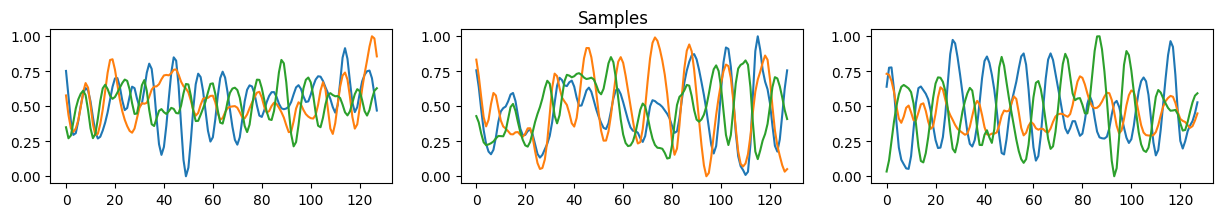

Train dataloader: 56
Val dataloader: 28
Test dataloader: 29
model duration, inhouse_dataset, 1 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid is created
Test data point shape: torch.Size([1, 3, 128])
Test inference result length: 4
Test reconstruct shape: torch.Size([1, 3, 128])
Test encode shape: torch.Size([1, 64, 16])
Optimizer AdamW is instantiated
Scheduler ReduceLROnPlateau is instantiated
Logging via WandB


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dmitriykornilov (dmitriykornilov_team). Use `wandb login --relogin` to force relogin


#################### duration, inhouse_dataset, 1 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid ####################
{
    "project_name": "EEG_depression_classification",
    "method": "direct restoration",
    "save_path": "model_weights/",
    "log_path": "logs/",
    "dataset": {
        "batch_size": 256,
        "num_workers": 0,
        "samples_shape": [
            3,
            128
        ],
        "train": {
            "name": "inhouse_dataset",
            "file": "Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/dataset_128_1.0.pkl",
            "size": null,
            "n_samples": 14277,
            "is_squeeze": false,
            "is_unsqueeze": false,
            "t_max": null
        },
        "val": {
            "name": "inhouse_dataset",
            "file": "Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/dataset_128_1.0.pkl",
            "size": 30,
            "n_samples":

  0%|                                                                                                                                                                                                        | 0/50 [00:00<?, ?it/s]

Epoch 0
##### Training... #####
Model is in train mode
Epoch time: 11.669873714447021 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.129,0.871,0.160,4.587,0.129,0.007,0.004,0.012,0.357,0.129,0.737,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 176.65284276008606 s
Epoch time: 181.2783966064453 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.081,0.919,0.192,6.103,0.081,0.007,0.004,0.012,0.284,0.081,0.515,0.587,0.602,0.578,0.575,0.587,0.021,0.588,0.022,0.551,0.017,0.551,0.017,0.565,0.591,0.540,0.564,0.558,0.545,0.541,0.031,0.542,0.029,0.533,0.024,0.532,0.025,0.529,0.587


  2%|███▊                                                                                                                                                                                         | 1/50 [03:13<2:37:38, 193.02s/it]

New best classifier accuracy = 0.5325629004277028 on epoch 0
Epoch 1
##### Training... #####
Model is in train mode
Epoch time: 11.926369190216064 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.065,0.935,0.206,6.928,0.065,0.007,0.004,0.012,0.254,0.065,0.645,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.667201042175293 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.046,0.954,0.211,8.163,0.046,0.007,0.004,0.012,0.215,0.046,0.538


  4%|███████▌                                                                                                                                                                                      | 2/50 [03:29<1:11:25, 89.27s/it]

Epoch 2
##### Training... #####
Model is in train mode
Epoch time: 11.929245948791504 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.040,0.960,0.222,8.739,0.040,0.007,0.004,0.012,0.200,0.040,0.598,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.7342119216918945 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.034,0.966,0.244,9.448,0.034,0.007,0.004,0.012,0.183,0.034,0.527


  6%|███████████▌                                                                                                                                                                                    | 3/50 [03:46<43:58, 56.14s/it]

Epoch 3
##### Training... #####
Model is in train mode
Epoch time: 12.222523927688599 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.033,0.967,0.241,9.568,0.033,0.007,0.004,0.012,0.181,0.033,0.560,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.703623294830322 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.031,0.969,0.260,9.790,0.031,0.007,0.004,0.012,0.177,0.031,0.474


  8%|███████████████▎                                                                                                                                                                                | 4/50 [04:03<31:11, 40.69s/it]

Epoch 4
##### Training... #####
Model is in train mode
Epoch time: 11.875294208526611 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.031,0.969,0.256,9.805,0.031,0.007,0.004,0.012,0.176,0.031,0.520,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.491833925247192 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.030,0.970,0.278,9.902,0.030,0.006,0.004,0.012,0.174,0.030,0.427


 10%|███████████████████▏                                                                                                                                                                            | 5/50 [04:19<23:57, 31.94s/it]

Epoch 5
##### Training... #####
Model is in train mode
Epoch time: 11.782057046890259 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.031,0.969,0.271,9.887,0.031,0.007,0.004,0.012,0.175,0.031,0.484,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 202.38226795196533 s
Epoch time: 206.93821907043457 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.030,0.970,0.284,9.900,0.030,0.006,0.004,0.012,0.174,0.030,0.468,0.599,0.601,0.574,0.580,0.599,0.022,0.599,0.023,0.552,0.017,0.552,0.017,0.578,0.570,0.555,0.558,0.539,0.539,0.556,0.031,0.556,0.031,0.513,0.023,0.513,0.023,0.547,0.532


 12%|██████████████████████▊                                                                                                                                                                       | 6/50 [07:58<1:10:00, 95.47s/it]

Epoch 6
##### Training... #####
Model is in train mode
Epoch time: 11.716074705123901 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.030,0.970,0.285,9.936,0.030,0.007,0.004,0.012,0.174,0.030,0.463,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.5644142627716064 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.030,0.970,0.299,9.986,0.030,0.006,0.004,0.012,0.173,0.030,0.404


 14%|██████████████████████████▉                                                                                                                                                                     | 7/50 [08:14<49:52, 69.60s/it]

Epoch 7
##### Training... #####
Model is in train mode
Epoch time: 11.957780599594116 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.030,0.970,0.302,9.990,0.030,0.007,0.004,0.012,0.173,0.030,0.445,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.584262371063232 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.029,0.971,0.330,10.065,0.029,0.006,0.004,0.012,0.171,0.029,0.408


 16%|██████████████████████████████▋                                                                                                                                                                 | 8/50 [08:31<36:54, 52.72s/it]

Epoch 8
##### Training... #####
Model is in train mode
Epoch time: 11.795702695846558 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.029,0.971,0.328,10.050,0.029,0.007,0.004,0.012,0.172,0.029,0.429,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.675513505935669 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.029,0.971,0.347,10.101,0.029,0.006,0.004,0.012,0.170,0.029,0.393


 18%|██████████████████████████████████▌                                                                                                                                                             | 9/50 [08:48<28:17, 41.41s/it]

Epoch 9
##### Training... #####
Model is in train mode
Epoch time: 11.766433238983154 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.029,0.971,0.346,10.114,0.029,0.007,0.004,0.012,0.170,0.029,0.415,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.659956932067871 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.029,0.971,0.364,10.165,0.029,0.006,0.004,0.012,0.169,0.029,0.396


 20%|██████████████████████████████████████▏                                                                                                                                                        | 10/50 [09:04<22:28, 33.71s/it]

Epoch 10
##### Training... #####
Model is in train mode
Epoch time: 11.89769959449768 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.029,0.971,0.360,10.162,0.029,0.006,0.004,0.012,0.169,0.029,0.403,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 167.35011196136475 s
Epoch time: 171.9380316734314 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.028,0.972,0.375,10.193,0.028,0.006,0.004,0.012,0.169,0.028,0.375,0.587,0.599,0.573,0.564,0.587,0.021,0.588,0.022,0.546,0.017,0.546,0.017,0.548,0.598,0.563,0.563,0.558,0.543,0.563,0.031,0.564,0.031,0.535,0.023,0.535,0.024,0.522,0.594


 22%|██████████████████████████████████████████                                                                                                                                                     | 11/50 [12:08<51:47, 79.68s/it]

New best classifier accuracy = 0.5352530898785257 on epoch 10
Epoch 11
##### Training... #####
Model is in train mode
Epoch time: 11.962636709213257 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.028,0.972,0.375,10.216,0.028,0.006,0.004,0.012,0.168,0.028,0.393,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.6997082233428955 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.028,0.972,0.384,10.226,0.028,0.006,0.004,0.012,0.168,0.028,0.391


 24%|█████████████████████████████████████████████▊                                                                                                                                                 | 12/50 [12:25<38:19, 60.52s/it]

Epoch 12
##### Training... #####
Model is in train mode
Epoch time: 11.671121835708618 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.028,0.972,0.388,10.263,0.028,0.006,0.004,0.012,0.167,0.028,0.384,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.727590322494507 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.028,0.972,0.402,10.319,0.028,0.006,0.004,0.012,0.166,0.028,0.370


 26%|█████████████████████████████████████████████████▋                                                                                                                                             | 13/50 [12:41<29:05, 47.17s/it]

Epoch 13
##### Training... #####
Model is in train mode
Epoch time: 11.918663024902344 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.028,0.972,0.403,10.324,0.028,0.006,0.004,0.012,0.166,0.028,0.376,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.651286363601685 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.028,0.972,0.406,10.306,0.028,0.006,0.004,0.012,0.166,0.028,0.404


 28%|█████████████████████████████████████████████████████▍                                                                                                                                         | 14/50 [12:58<22:46, 37.95s/it]

Epoch 14
##### Training... #####
Model is in train mode
Epoch time: 11.941634178161621 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.027,0.973,0.415,10.376,0.027,0.006,0.004,0.012,0.165,0.027,0.370,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 5.14866304397583 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.027,0.973,0.416,10.363,0.027,0.006,0.004,0.012,0.165,0.027,0.399


 30%|█████████████████████████████████████████████████████████▎                                                                                                                                     | 15/50 [13:15<18:28, 31.67s/it]

Epoch 15
##### Training... #####
Model is in train mode
Epoch time: 11.884450435638428 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.027,0.973,0.426,10.423,0.027,0.006,0.004,0.012,0.164,0.027,0.365,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 133.41828608512878 s
Epoch time: 138.05959701538086 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.027,0.973,0.432,10.438,0.027,0.006,0.004,0.012,0.164,0.027,0.366,0.594,0.602,0.576,0.573,0.595,0.022,0.594,0.022,0.548,0.017,0.549,0.017,0.564,0.588,0.550,0.578,0.565,0.568,0.551,0.030,0.552,0.030,0.538,0.024,0.538,0.024,0.572,0.557


 32%|█████████████████████████████████████████████████████████████                                                                                                                                  | 16/50 [15:45<38:08, 67.29s/it]

New best classifier accuracy = 0.5378075640099198 on epoch 15
Epoch 16
##### Training... #####
Model is in train mode
Epoch time: 11.606497049331665 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.027,0.973,0.436,10.465,0.027,0.006,0.004,0.012,0.163,0.027,0.360,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.489625930786133 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.026,0.974,0.448,10.489,0.026,0.006,0.004,0.012,0.163,0.026,0.366


 34%|████████████████████████████████████████████████████████████████▉                                                                                                                              | 17/50 [16:01<28:33, 51.91s/it]

Epoch 17
##### Training... #####
Model is in train mode
Epoch time: 11.937770128250122 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.026,0.974,0.449,10.529,0.026,0.006,0.004,0.012,0.162,0.026,0.357,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.84331750869751 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.026,0.974,0.457,10.554,0.026,0.006,0.004,0.012,0.161,0.026,0.355


 36%|████████████████████████████████████████████████████████████████████▊                                                                                                                          | 18/50 [16:18<22:03, 41.37s/it]

Epoch 18
##### Training... #####
Model is in train mode
Epoch time: 11.723244428634644 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.026,0.974,0.455,10.561,0.026,0.006,0.004,0.012,0.161,0.026,0.354,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.599210739135742 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.026,0.974,0.463,10.591,0.026,0.006,0.004,0.012,0.161,0.026,0.357


 38%|████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 19/50 [16:34<17:29, 33.87s/it]

Epoch 19
##### Training... #####
Model is in train mode
Epoch time: 11.769072532653809 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.026,0.974,0.465,10.607,0.026,0.006,0.004,0.012,0.160,0.026,0.352,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.521493196487427 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.474,10.652,0.025,0.006,0.004,0.012,0.160,0.025,0.352


 40%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 20/50 [16:51<14:18, 28.61s/it]

Epoch 20
##### Training... #####
Model is in train mode
Epoch time: 11.616005420684814 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.026,0.974,0.471,10.639,0.026,0.006,0.004,0.012,0.160,0.026,0.350,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 123.36335015296936 s
Epoch time: 127.90710282325745 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.025,0.975,0.474,10.648,0.025,0.006,0.004,0.012,0.160,0.025,0.358,0.580,0.598,0.573,0.544,0.581,0.021,0.581,0.022,0.543,0.017,0.543,0.017,0.510,0.635,0.566,0.569,0.550,0.532,0.567,0.031,0.567,0.029,0.538,0.024,0.539,0.024,0.502,0.600


 42%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 21/50 [19:10<29:55, 61.92s/it]

New best classifier accuracy = 0.53841389964472 on epoch 20
Epoch 21
##### Training... #####
Model is in train mode
Epoch time: 11.935221672058105 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.478,10.678,0.025,0.006,0.004,0.012,0.159,0.025,0.348,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.692667007446289 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.482,10.704,0.025,0.006,0.004,0.012,0.158,0.025,0.354


 44%|████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 22/50 [19:27<22:33, 48.34s/it]

Epoch 22
##### Training... #####
Model is in train mode
Epoch time: 11.937480449676514 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.484,10.718,0.025,0.006,0.004,0.012,0.158,0.025,0.347,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.6173975467681885 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.488,10.683,0.025,0.006,0.004,0.012,0.159,0.025,0.352


 46%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 23/50 [19:43<17:28, 38.82s/it]

Epoch 23
##### Training... #####
Model is in train mode
Epoch time: 12.010995626449585 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.491,10.757,0.025,0.006,0.004,0.012,0.158,0.025,0.346,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.664234161376953 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.498,10.789,0.025,0.006,0.004,0.012,0.157,0.025,0.341


 48%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 24/50 [20:00<13:57, 32.20s/it]

Epoch 24
##### Training... #####
Model is in train mode
Epoch time: 11.916406393051147 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.496,10.787,0.025,0.006,0.004,0.012,0.157,0.025,0.346,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.58474588394165 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.503,10.813,0.024,0.006,0.004,0.012,0.156,0.024,0.340


 50%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 25/50 [20:17<11:27, 27.50s/it]

Epoch 25
##### Training... #####
Model is in train mode
Epoch time: 11.552942037582397 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.024,0.976,0.502,10.821,0.024,0.006,0.004,0.012,0.156,0.024,0.346,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 171.3013253211975 s
Epoch time: 175.89657163619995 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.024,0.976,0.506,10.841,0.024,0.006,0.004,0.012,0.156,0.024,0.351,0.593,0.605,0.573,0.558,0.595,0.021,0.594,0.022,0.547,0.017,0.546,0.017,0.535,0.612,0.551,0.553,0.537,0.528,0.551,0.030,0.552,0.030,0.523,0.023,0.523,0.023,0.515,0.559


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 26/50 [23:24<30:12, 75.51s/it]

Epoch 26
##### Training... #####
Model is in train mode
Epoch time: 12.355327129364014 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.024,0.976,0.508,10.855,0.024,0.006,0.004,0.012,0.156,0.024,0.345,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.6486406326293945 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.517,10.909,0.024,0.006,0.004,0.012,0.155,0.024,0.342


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 27/50 [23:41<22:13, 57.98s/it]

Epoch 27
##### Training... #####
Model is in train mode
Epoch time: 11.713505029678345 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.024,0.976,0.512,10.879,0.024,0.006,0.004,0.012,0.155,0.024,0.345,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.639644384384155 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.520,10.915,0.024,0.006,0.004,0.012,0.155,0.024,0.344


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 28/50 [23:58<16:41, 45.50s/it]

Epoch 28
##### Training... #####
Model is in train mode
Epoch time: 11.830243587493896 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.024,0.976,0.515,10.905,0.024,0.006,0.004,0.012,0.155,0.024,0.345,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.65710711479187 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.522,10.940,0.024,0.006,0.004,0.012,0.154,0.024,0.343


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 29/50 [24:14<12:53, 36.81s/it]

Epoch 29
##### Training... #####
Model is in train mode
Epoch time: 11.942354679107666 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.024,0.976,0.521,10.931,0.024,0.006,0.004,0.012,0.154,0.024,0.345,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.693860054016113 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.523,10.932,0.024,0.006,0.004,0.012,0.154,0.024,0.335


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 30/50 [24:31<10:15, 30.78s/it]

Epoch 30
##### Training... #####
Model is in train mode
Epoch time: 11.802600860595703 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.024,0.976,0.525,10.964,0.024,0.006,0.004,0.012,0.154,0.024,0.345,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 121.78109693527222 s
Epoch time: 126.35012030601501 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.024,0.976,0.530,10.953,0.024,0.006,0.004,0.012,0.154,0.024,0.334,0.587,0.596,0.574,0.577,0.588,0.021,0.588,0.022,0.546,0.017,0.546,0.017,0.578,0.569,0.524,0.524,0.514,0.514,0.524,0.029,0.525,0.028,0.512,0.023,0.512,0.023,0.510,0.518


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 31/50 [26:49<19:57, 63.01s/it]

Epoch 31
##### Training... #####
Model is in train mode
Epoch time: 11.932838439941406 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.529,10.980,0.023,0.006,0.004,0.012,0.153,0.023,0.346,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.590984582901001 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.023,0.977,0.532,11.007,0.023,0.006,0.004,0.012,0.153,0.023,0.346


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 32/50 [27:06<14:43, 49.08s/it]

Epoch 32
##### Training... #####
Model is in train mode
Epoch time: 12.05188798904419 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.532,11.003,0.023,0.006,0.004,0.012,0.153,0.023,0.346,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.570114612579346 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.533,10.950,0.024,0.006,0.004,0.012,0.154,0.024,0.340


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 33/50 [27:22<11:09, 39.36s/it]

Epoch 33
##### Training... #####
Model is in train mode
Epoch time: 11.692093849182129 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.536,11.032,0.023,0.006,0.004,0.012,0.152,0.023,0.346,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.62856388092041 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.023,0.977,0.541,11.057,0.023,0.006,0.004,0.012,0.152,0.023,0.348


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 34/50 [27:39<08:39, 32.46s/it]

Epoch 34
##### Training... #####
Model is in train mode
Epoch time: 11.994052410125732 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.539,11.052,0.023,0.006,0.004,0.012,0.152,0.023,0.347,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.59568977355957 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.023,0.977,0.541,11.043,0.023,0.006,0.004,0.012,0.152,0.023,0.348


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 35/50 [27:55<06:55, 27.72s/it]

Epoch 35
##### Training... #####
Model is in train mode
Epoch time: 11.899990320205688 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.543,11.070,0.023,0.006,0.004,0.012,0.152,0.023,0.347,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 121.9247236251831 s
Epoch time: 126.40052366256714 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.023,0.977,0.545,11.064,0.023,0.006,0.004,0.012,0.152,0.023,0.342,0.574,0.593,0.572,0.573,0.575,0.021,0.575,0.021,0.549,0.017,0.549,0.017,0.566,0.578,0.553,0.572,0.549,0.545,0.554,0.030,0.555,0.029,0.524,0.024,0.524,0.024,0.545,0.552


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 36/50 [30:14<14:12, 60.91s/it]

Epoch 36
##### Training... #####
Model is in train mode
Epoch time: 11.887951135635376 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.545,11.083,0.023,0.006,0.004,0.012,0.151,0.023,0.347,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.703144073486328 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.023,0.977,0.548,11.074,0.023,0.006,0.004,0.012,0.152,0.023,0.346


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 37/50 [30:30<10:19, 47.63s/it]

Epoch 37
##### Training... #####
Model is in train mode
Epoch time: 11.804521322250366 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.548,11.106,0.023,0.006,0.004,0.012,0.151,0.023,0.348,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.629045724868774 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.023,0.977,0.551,11.133,0.023,0.006,0.004,0.012,0.151,0.023,0.347


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 38/50 [30:47<07:39, 38.29s/it]

Epoch 38
##### Training... #####
Model is in train mode
Epoch time: 11.575016021728516 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.550,11.122,0.023,0.006,0.004,0.012,0.151,0.023,0.348,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.577117681503296 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.023,0.977,0.549,11.061,0.023,0.006,0.004,0.012,0.152,0.023,0.355


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 39/50 [31:05<05:55, 32.28s/it]

Epoch 39
##### Training... #####
Model is in train mode
Epoch time: 11.775086641311646 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.552,11.138,0.023,0.006,0.004,0.012,0.150,0.023,0.349,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.6512346267700195 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.023,0.977,0.553,11.132,0.023,0.006,0.004,0.012,0.151,0.023,0.345


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 40/50 [31:22<04:35, 27.55s/it]

Epoch 40
##### Training... #####
Model is in train mode
Epoch time: 11.692667722702026 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.554,11.152,0.023,0.006,0.004,0.012,0.150,0.023,0.349,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 176.49407625198364 s
Epoch time: 181.0038366317749 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.023,0.977,0.556,11.148,0.023,0.006,0.004,0.012,0.150,0.023,0.351,0.595,0.609,0.580,0.580,0.596,0.022,0.595,0.021,0.554,0.017,0.553,0.017,0.572,0.589,0.562,0.572,0.548,0.541,0.562,0.032,0.563,0.030,0.524,0.024,0.523,0.023,0.535,0.562


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 41/50 [34:34<11:34, 77.11s/it]

Epoch 41
##### Training... #####
Model is in train mode
Epoch time: 11.697540998458862 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.022,0.978,0.557,11.166,0.022,0.006,0.004,0.012,0.150,0.022,0.350,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.580962657928467 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.022,0.978,0.559,11.172,0.022,0.006,0.004,0.012,0.150,0.022,0.352


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 42/50 [34:51<07:51, 58.88s/it]

Epoch 42
##### Training... #####
Model is in train mode
Epoch time: 11.640049934387207 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.022,0.978,0.559,11.182,0.022,0.006,0.004,0.012,0.150,0.022,0.351,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.510933876037598 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.022,0.978,0.561,11.182,0.022,0.006,0.004,0.012,0.150,0.022,0.343


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 43/50 [35:07<05:22, 46.08s/it]

Epoch 43
##### Training... #####
Model is in train mode
Epoch time: 11.658125877380371 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.022,0.978,0.559,11.187,0.022,0.006,0.004,0.012,0.150,0.022,0.351,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.519591331481934 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.022,0.978,0.563,11.226,0.022,0.006,0.004,0.012,0.149,0.022,0.361


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 44/50 [35:23<03:42, 37.12s/it]

Epoch 44
##### Training... #####
Model is in train mode
Epoch time: 11.709474086761475 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.022,0.978,0.562,11.210,0.022,0.006,0.004,0.012,0.149,0.022,0.352,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.486213207244873 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.022,0.978,0.562,11.187,0.022,0.006,0.004,0.012,0.150,0.022,0.360


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 45/50 [35:39<02:34, 30.86s/it]

Epoch 45
##### Training... #####
Model is in train mode
Epoch time: 11.905120372772217 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.022,0.978,0.564,11.221,0.022,0.006,0.004,0.012,0.149,0.022,0.352,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 182.4052619934082 s
Epoch time: 186.94848775863647 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.022,0.978,0.570,11.250,0.022,0.006,0.004,0.012,0.149,0.022,0.352,0.578,0.598,0.565,0.525,0.578,0.022,0.578,0.022,0.535,0.017,0.535,0.017,0.483,0.645,0.565,0.569,0.544,0.517,0.566,0.029,0.567,0.029,0.542,0.024,0.542,0.024,0.473,0.619


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 46/50 [38:58<05:25, 81.28s/it]

New best classifier accuracy = 0.5415865007849392 on epoch 45
Epoch 46
##### Training... #####
Model is in train mode
Epoch time: 11.76786470413208 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.022,0.978,0.565,11.230,0.022,0.006,0.004,0.012,0.149,0.022,0.353,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.689895868301392 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.022,0.978,0.567,11.217,0.022,0.006,0.004,0.012,0.149,0.022,0.347


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 47/50 [39:15<03:05, 61.85s/it]

Epoch 47
##### Training... #####
Model is in train mode
Epoch time: 11.6212158203125 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.022,0.978,0.567,11.243,0.022,0.006,0.004,0.012,0.149,0.022,0.353,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.5973429679870605 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.022,0.978,0.569,11.272,0.022,0.006,0.004,0.012,0.148,0.022,0.343


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 48/50 [39:31<01:36, 48.17s/it]

Epoch 48
##### Training... #####
Model is in train mode
Epoch time: 11.680317401885986 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.022,0.978,0.569,11.254,0.022,0.006,0.004,0.012,0.148,0.022,0.353,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.664235591888428 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.022,0.978,0.565,11.215,0.022,0.006,0.004,0.012,0.149,0.022,0.333


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 49/50 [39:48<00:38, 38.64s/it]

Epoch 49
##### Training... #####
Model is in train mode
Epoch time: 11.81902003288269 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.022,0.978,0.570,11.264,0.022,0.006,0.003,0.012,0.148,0.022,0.354,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 4.5891382694244385 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.022,0.978,0.570,11.257,0.022,0.006,0.004,0.012,0.148,0.022,0.357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [40:04<00:00, 48.09s/it]

##### Testing in final mode... #####
Model is in evaluation mode
Epoch 50, step 0
Plotting PCA...


,Explained variance,Ratio
0,0.000945,0.492550
1,0.000351,0.182718


Plotting reconstruction...


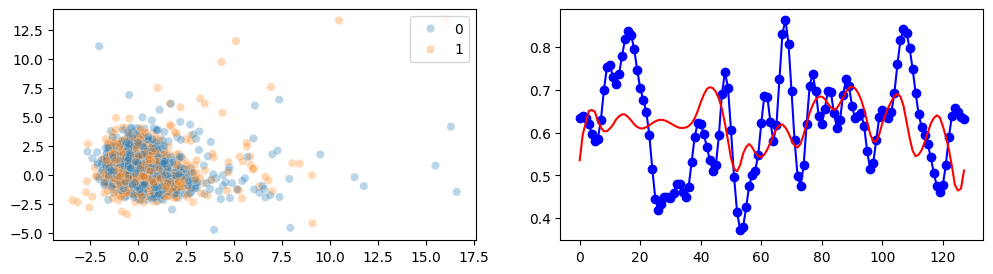

Plotting time: 1.6036651134490967 s
Classifier/regressor metrics evaluation...
Embeddings shape: (7326, 64)
Evaluation time: 204.70802402496338 s
Epoch time: 211.09048652648926 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.022,0.978,0.567,11.218,0.022,0.006,0.003,0.012,0.149,0.022,0.358,0.550,0.584,0.546,0.233,0.550,0.022,0.551,0.021,0.501,0.016,0.501,0.015,0.143,0.919,0.509,0.530,0.516,0.211,0.510,0.027,0.509,0.028,0.492,0.021,0.492,0.021,0.132,0.882


##### Testing in test mode... #####
Model is in evaluation mode
Epoch 50, step 0
Plotting PCA...


,Explained variance,Ratio
0,0.000945,0.492550
1,0.000351,0.182718


Plotting reconstruction...


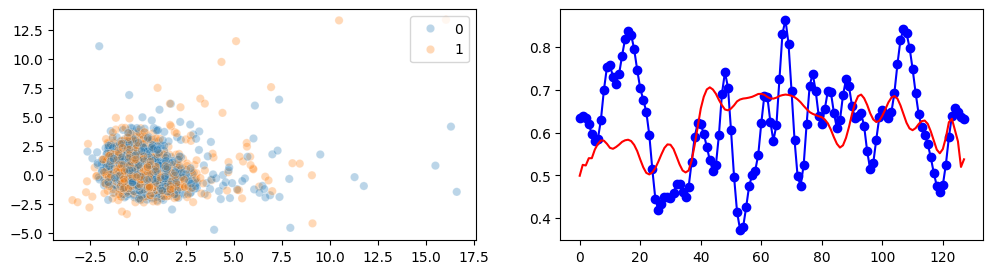

Plotting time: 1.5804696083068848 s
Classifier/regressor metrics evaluation...
Embeddings shape: (7326, 64)
Evaluation time: 192.04060578346252 s
Epoch time: 198.45440888404846 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.022,0.978,0.567,11.222,0.022,0.006,0.003,0.012,0.149,0.022,0.358,0.543,0.581,0.540,0.190,0.544,0.022,0.544,0.021,0.492,0.015,0.493,0.015,0.113,0.931,0.527,0.532,0.521,0.173,0.528,0.028,0.528,0.029,0.502,0.021,0.503,0.021,0.102,0.928


Data reading

Chunks shape: (3, 256) , length: 7117 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 149
Train=149, validation=0, test=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7117/7117 [00:00<00:00, 15446.70it/s]


Train: 7117 (3, 256)

Chunks shape: (3, 256) , length: 7117 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 149
Train=0, validation=74, test=75


  0%|                                                                                                                                                                                                      | 0/7117 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 3946/7117 [00:00<00:00, 19730.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7117/7117 [00:00<00:00, 20187.81it/s]

Validation: 3466 (3, 256)
Test: 3651 (3, 256)
Train dataset: 7117
Val dataset: 3466
Test dataset: 3651
Train sample shape: torch.Size([3, 256])
Val sample shape: torch.Size([3, 256])
Test sample shape: torch.Size([3, 256])
Train sample type: torch.FloatTensor
Val sample type: torch.FloatTensor
Test sample type: torch.FloatTensor


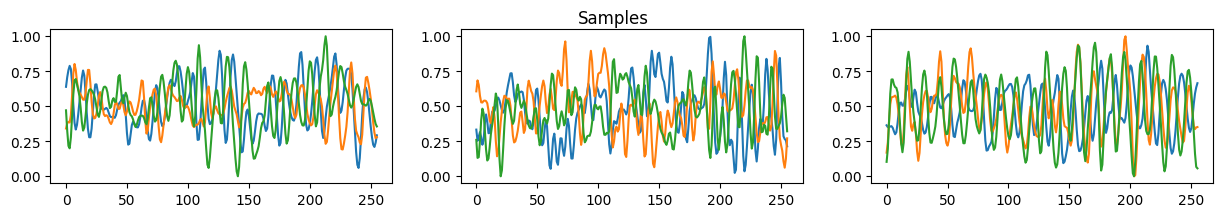

Train dataloader: 28
Val dataloader: 14
Test dataloader: 15
model duration, inhouse_dataset, 2 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid is created
Test data point shape: torch.Size([1, 3, 256])
Test inference result length: 4
Test reconstruct shape: torch.Size([1, 3, 256])
Test encode shape: torch.Size([1, 64, 32])
Optimizer AdamW is instantiated
Scheduler ReduceLROnPlateau is instantiated
Logging via WandB


#################### duration, inhouse_dataset, 2 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid ####################
{
    "project_name": "EEG_depression_classification",
    "method": "direct restoration",
    "save_path": "model_weights/",
    "log_path": "logs/",
    "dataset": {
        "batch_size": 256,
        "num_workers": 0,
        "samples_shape": [
            3,
            256
        ],
        "train": {
            "name": "inhouse_dataset",
            "file": "Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/dataset_128_2.0.pkl",
            "size": null,
            "n_samples": 7117,
            "is_squeeze": false,
            "is_unsqueeze": false,
            "t_max": null
        },
        "val": {
            "name": "inhouse_dataset",
            "file": "Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/dataset_128_2.0.pkl",
            "size": 30,
            "n_samples": 

  0%|                                                                                                                                                                                                        | 0/50 [00:00<?, ?it/s]

Epoch 0
##### Training... #####
Model is in train mode
Epoch time: 6.540167331695557 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.879,0.121,0.152,-3.457,0.879,0.006,0.003,0.006,0.937,0.879,0.763,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (3466, 64)
Evaluation time: 49.96026086807251 s
Epoch time: 52.52654790878296 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.804,0.196,0.007,-2.839,0.804,0.005,0.003,0.006,0.897,0.804,0.438,0.567,0.588,0.567,0.451,0.568,0.030,0.567,0.030,0.531,0.024,0.531,0.023,0.361,0.767,0.564,0.556,0.531,0.419,0.565,0.042,0.566,0.041,0.550,0.033,0.549,0.035,0.321,0.764


  2%|███▊                                                                                                                                                                                            | 1/50 [00:59<48:18, 59.15s/it]

New best classifier accuracy = 0.5500394013103282 on epoch 0
Epoch 1
##### Training... #####
Model is in train mode
Epoch time: 6.605413913726807 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.736,0.264,0.197,-2.344,0.736,0.005,0.003,0.006,0.857,0.736,0.692,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.700547218322754 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.650,0.350,0.198,-1.507,0.650,0.005,0.003,0.006,0.806,0.650,0.657


  4%|███████▋                                                                                                                                                                                        | 2/50 [01:08<23:53, 29.86s/it]

Epoch 2
##### Training... #####
Model is in train mode
Epoch time: 6.340775489807129 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.616,0.384,0.201,-1.238,0.616,0.005,0.003,0.006,0.785,0.616,0.684,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.6319713592529297 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.513,0.487,0.195,-0.019,0.513,0.005,0.003,0.006,0.716,0.513,0.686


  6%|███████████▌                                                                                                                                                                                    | 3/50 [01:17<15:56, 20.35s/it]

Epoch 3
##### Training... #####
Model is in train mode
Epoch time: 6.451640367507935 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.513,0.487,0.186,-0.183,0.513,0.005,0.003,0.006,0.716,0.513,0.679,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.6639657020568848 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.495,0.505,0.149,-0.064,0.495,0.005,0.003,0.006,0.703,0.495,0.681


  8%|███████████████▎                                                                                                                                                                                | 4/50 [01:26<12:13, 15.94s/it]

Epoch 4
##### Training... #####
Model is in train mode
Epoch time: 6.497124195098877 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.426,0.574,0.181,0.747,0.426,0.005,0.003,0.006,0.652,0.426,0.677,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.5874671936035156 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.425,0.575,0.123,0.604,0.425,0.005,0.003,0.006,0.652,0.425,0.717


 10%|███████████████████▏                                                                                                                                                                            | 5/50 [01:35<10:07, 13.49s/it]

Epoch 5
##### Training... #####
Model is in train mode
Epoch time: 6.2783589363098145 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.352,0.648,0.185,1.520,0.352,0.005,0.003,0.006,0.593,0.352,0.674,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (3466, 64)
Evaluation time: 41.232290267944336 s
Epoch time: 43.761340618133545 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.329,0.671,0.151,1.745,0.329,0.005,0.003,0.006,0.574,0.329,0.724,0.637,0.635,0.598,0.592,0.638,0.029,0.638,0.030,0.567,0.024,0.567,0.024,0.574,0.622,0.569,0.609,0.589,0.582,0.572,0.043,0.570,0.043,0.549,0.033,0.548,0.034,0.578,0.600


 12%|███████████████████████                                                                                                                                                                         | 6/50 [02:25<19:01, 25.94s/it]

Epoch 6
##### Training... #####
Model is in train mode
Epoch time: 6.682745695114136 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.289,0.711,0.183,2.204,0.289,0.005,0.003,0.006,0.538,0.289,0.661,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.6526567935943604 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.263,0.737,0.133,2.507,0.263,0.005,0.003,0.006,0.513,0.263,0.790


 14%|██████████████████████████▉                                                                                                                                                                     | 7/50 [02:35<14:42, 20.53s/it]

Epoch 7
##### Training... #####
Model is in train mode
Epoch time: 6.369920492172241 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.237,0.763,0.187,2.852,0.237,0.005,0.003,0.006,0.486,0.237,0.652,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.49221134185791 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.194,0.806,0.166,3.411,0.194,0.005,0.003,0.006,0.441,0.194,0.713


 16%|██████████████████████████████▋                                                                                                                                                                 | 8/50 [02:44<11:47, 16.84s/it]

Epoch 8
##### Training... #####
Model is in train mode
Epoch time: 6.564171075820923 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.193,0.807,0.190,3.497,0.193,0.005,0.003,0.006,0.439,0.193,0.646,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.522160530090332 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.172,0.828,0.209,3.873,0.172,0.005,0.003,0.006,0.414,0.172,0.654


 18%|██████████████████████████████████▌                                                                                                                                                             | 9/50 [02:53<09:51, 14.43s/it]

Epoch 9
##### Training... #####
Model is in train mode
Epoch time: 6.464997291564941 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.156,0.844,0.196,4.146,0.156,0.005,0.003,0.006,0.395,0.156,0.642,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.5284154415130615 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.140,0.860,0.206,4.545,0.140,0.005,0.003,0.006,0.374,0.140,0.599


 20%|██████████████████████████████████████▏                                                                                                                                                        | 10/50 [03:02<08:30, 12.77s/it]

Epoch 10
##### Training... #####
Model is in train mode
Epoch time: 6.678511381149292 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.126,0.874,0.198,4.833,0.126,0.005,0.003,0.006,0.355,0.126,0.637,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (3466, 64)
Evaluation time: 36.73159384727478 s
Epoch time: 39.26771688461304 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.112,0.888,0.199,5.256,0.112,0.005,0.003,0.006,0.334,0.112,0.619,0.583,0.608,0.575,0.480,0.585,0.030,0.584,0.031,0.534,0.024,0.534,0.024,0.400,0.743,0.603,0.577,0.540,0.464,0.605,0.042,0.605,0.042,0.561,0.032,0.560,0.033,0.376,0.726


 22%|██████████████████████████████████████████                                                                                                                                                     | 11/50 [03:48<14:54, 22.95s/it]

New best classifier accuracy = 0.5606266059940089 on epoch 10
Epoch 11
##### Training... #####
Model is in train mode
Epoch time: 6.47048282623291 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.102,0.898,0.204,5.522,0.102,0.005,0.003,0.006,0.319,0.102,0.632,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.526547908782959 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.083,0.917,0.205,6.166,0.083,0.005,0.003,0.006,0.288,0.083,0.621


 24%|█████████████████████████████████████████████▊                                                                                                                                                 | 12/50 [03:57<11:51, 18.72s/it]

Epoch 12
##### Training... #####
Model is in train mode
Epoch time: 6.502730131149292 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.083,0.917,0.206,6.200,0.083,0.005,0.003,0.006,0.288,0.083,0.626,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.602799892425537 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.071,0.929,0.202,6.710,0.071,0.005,0.003,0.006,0.266,0.071,0.606


 26%|█████████████████████████████████████████████████▋                                                                                                                                             | 13/50 [04:06<09:45, 15.83s/it]

Epoch 13
##### Training... #####
Model is in train mode
Epoch time: 6.642186880111694 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.068,0.932,0.210,6.861,0.068,0.005,0.003,0.006,0.261,0.068,0.620,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.731038808822632 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.062,0.938,0.218,7.245,0.062,0.005,0.003,0.006,0.248,0.062,0.542


 28%|█████████████████████████████████████████████████████▍                                                                                                                                         | 14/50 [04:16<08:20, 13.89s/it]

Epoch 14
##### Training... #####
Model is in train mode
Epoch time: 6.402253866195679 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.057,0.943,0.214,7.499,0.057,0.005,0.003,0.006,0.238,0.057,0.613,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.5966572761535645 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.051,0.949,0.227,7.862,0.051,0.005,0.003,0.006,0.227,0.051,0.552


 30%|█████████████████████████████████████████████████████████▎                                                                                                                                     | 15/50 [04:25<07:15, 12.44s/it]

Epoch 15
##### Training... #####
Model is in train mode
Epoch time: 6.5284295082092285 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.048,0.952,0.220,8.086,0.048,0.005,0.003,0.006,0.219,0.048,0.606,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (3466, 64)
Evaluation time: 50.48947596549988 s
Epoch time: 52.99909830093384 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.043,0.957,0.226,8.482,0.043,0.005,0.003,0.006,0.208,0.043,0.582,0.603,0.629,0.596,0.525,0.603,0.030,0.604,0.032,0.548,0.024,0.549,0.026,0.455,0.731,0.596,0.594,0.569,0.541,0.598,0.043,0.599,0.043,0.574,0.034,0.574,0.034,0.479,0.671


 32%|█████████████████████████████████████████████████████████████                                                                                                                                  | 16/50 [05:24<15:05, 26.63s/it]

New best classifier accuracy = 0.5740198573197306 on epoch 15
Epoch 16
##### Training... #####
Model is in train mode
Epoch time: 6.493378162384033 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.042,0.958,0.227,8.608,0.042,0.005,0.003,0.006,0.204,0.042,0.597,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.658338785171509 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.039,0.961,0.228,8.804,0.039,0.005,0.003,0.006,0.198,0.039,0.607


 34%|████████████████████████████████████████████████████████████████▉                                                                                                                              | 17/50 [05:34<11:45, 21.39s/it]

Epoch 17
##### Training... #####
Model is in train mode
Epoch time: 6.447216033935547 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.037,0.963,0.232,9.055,0.037,0.005,0.003,0.006,0.192,0.037,0.588,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.5297067165374756 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.038,0.962,0.248,8.990,0.038,0.005,0.003,0.006,0.195,0.038,0.561


 36%|████████████████████████████████████████████████████████████████████▊                                                                                                                          | 18/50 [05:43<09:25, 17.68s/it]

Epoch 18
##### Training... #####
Model is in train mode
Epoch time: 6.889073848724365 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.033,0.967,0.241,9.443,0.033,0.005,0.003,0.006,0.183,0.033,0.581,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.714458465576172 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.030,0.970,0.233,9.846,0.030,0.005,0.003,0.006,0.173,0.030,0.665


 38%|████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 19/50 [05:52<07:53, 15.27s/it]

Epoch 19
##### Training... #####
Model is in train mode
Epoch time: 6.621761083602905 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.031,0.969,0.248,9.748,0.031,0.005,0.003,0.006,0.176,0.031,0.573,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.6763932704925537 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.028,0.972,0.252,10.158,0.028,0.005,0.003,0.006,0.167,0.028,0.533


 40%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 20/50 [06:02<06:45, 13.50s/it]

Epoch 20
##### Training... #####
Model is in train mode
Epoch time: 6.328328609466553 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.029,0.971,0.251,9.977,0.029,0.005,0.003,0.006,0.171,0.029,0.569,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (3466, 64)
Evaluation time: 50.53519535064697 s
Epoch time: 53.04245567321777 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.027,0.973,0.262,10.334,0.027,0.005,0.003,0.006,0.164,0.027,0.539,0.602,0.618,0.593,0.571,0.603,0.032,0.604,0.031,0.560,0.024,0.560,0.024,0.537,0.650,0.567,0.587,0.558,0.526,0.569,0.041,0.569,0.042,0.536,0.034,0.537,0.034,0.488,0.629


 42%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 21/50 [07:01<13:11, 27.29s/it]

Epoch 21
##### Training... #####
Model is in train mode
Epoch time: 6.43081521987915 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.028,0.972,0.256,10.157,0.028,0.005,0.003,0.006,0.167,0.028,0.565,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.6700668334960938 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.027,0.973,0.260,10.375,0.027,0.005,0.003,0.006,0.163,0.027,0.619


 44%|████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 22/50 [07:10<10:11, 21.85s/it]

Epoch 22
##### Training... #####
Model is in train mode
Epoch time: 6.809473752975464 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.027,0.973,0.264,10.311,0.027,0.005,0.003,0.006,0.164,0.027,0.557,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.685811758041382 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.280,10.584,0.025,0.005,0.003,0.006,0.159,0.025,0.417


 46%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 23/50 [07:20<08:10, 18.16s/it]

Epoch 23
##### Training... #####
Model is in train mode
Epoch time: 6.462631702423096 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.026,0.974,0.267,10.408,0.026,0.005,0.003,0.006,0.162,0.026,0.552,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.614551067352295 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.026,0.974,0.265,10.528,0.026,0.005,0.003,0.006,0.160,0.026,0.617


 48%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 24/50 [07:29<06:41, 15.45s/it]

Epoch 24
##### Training... #####
Model is in train mode
Epoch time: 6.569691896438599 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.026,0.974,0.272,10.486,0.026,0.005,0.003,0.006,0.161,0.026,0.545,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.5490121841430664 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.275,10.579,0.025,0.005,0.003,0.006,0.159,0.025,0.585


 50%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 25/50 [07:38<05:39, 13.57s/it]

Epoch 25
##### Training... #####
Model is in train mode
Epoch time: 6.361013174057007 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.026,0.974,0.276,10.544,0.026,0.005,0.003,0.006,0.160,0.026,0.538,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (3466, 64)
Evaluation time: 36.81712865829468 s
Epoch time: 39.31538462638855 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.027,0.973,0.292,10.363,0.027,0.005,0.003,0.006,0.163,0.027,0.450,0.591,0.601,0.578,0.584,0.593,0.031,0.592,0.030,0.552,0.024,0.552,0.023,0.585,0.571,0.555,0.558,0.526,0.520,0.557,0.043,0.557,0.043,0.512,0.033,0.511,0.033,0.518,0.535


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 26/50 [08:24<09:17, 23.23s/it]

Epoch 26
##### Training... #####
Model is in train mode
Epoch time: 6.464501857757568 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.282,10.594,0.025,0.005,0.003,0.006,0.159,0.025,0.532,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.600492238998413 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.291,10.641,0.025,0.005,0.003,0.006,0.158,0.025,0.507


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 27/50 [08:33<07:16, 19.00s/it]

Epoch 27
##### Training... #####
Model is in train mode
Epoch time: 6.482059001922607 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.284,10.626,0.025,0.005,0.003,0.006,0.158,0.025,0.526,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.7565033435821533 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.287,10.668,0.025,0.005,0.003,0.006,0.158,0.025,0.540


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 28/50 [08:42<05:53, 16.09s/it]

Epoch 28
##### Training... #####
Model is in train mode
Epoch time: 6.451616287231445 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.289,10.670,0.025,0.005,0.003,0.006,0.158,0.025,0.518,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.600038528442383 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.300,10.680,0.025,0.005,0.003,0.006,0.157,0.025,0.455


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 29/50 [08:51<04:53, 14.00s/it]

Epoch 29
##### Training... #####
Model is in train mode
Epoch time: 6.577306509017944 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.291,10.690,0.025,0.005,0.003,0.006,0.157,0.025,0.511,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.6204752922058105 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.292,10.680,0.025,0.005,0.003,0.006,0.157,0.025,0.577


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 30/50 [09:01<04:11, 12.57s/it]

Epoch 30
##### Training... #####
Model is in train mode
Epoch time: 6.804506540298462 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.296,10.713,0.025,0.005,0.003,0.006,0.157,0.025,0.504,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (3466, 64)
Evaluation time: 43.53332161903381 s
Epoch time: 46.066564321517944 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.025,0.975,0.298,10.702,0.025,0.005,0.003,0.006,0.157,0.025,0.543,0.619,0.623,0.592,0.581,0.621,0.030,0.620,0.031,0.558,0.025,0.558,0.024,0.562,0.621,0.547,0.549,0.552,0.538,0.550,0.043,0.549,0.043,0.533,0.032,0.533,0.034,0.518,0.586


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 31/50 [09:54<07:49, 24.68s/it]

Epoch 31
##### Training... #####
Model is in train mode
Epoch time: 6.388725996017456 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.025,0.975,0.299,10.735,0.025,0.005,0.003,0.006,0.157,0.025,0.497,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.584747314453125 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.025,0.975,0.306,10.699,0.025,0.005,0.003,0.006,0.157,0.025,0.497


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 32/50 [10:03<05:59, 19.99s/it]

Epoch 32
##### Training... #####
Model is in train mode
Epoch time: 6.622273683547974 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.024,0.976,0.304,10.765,0.024,0.005,0.003,0.006,0.156,0.024,0.488,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.5906786918640137 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.305,10.766,0.024,0.005,0.003,0.006,0.156,0.024,0.503


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 33/50 [10:12<04:45, 16.77s/it]

Epoch 33
##### Training... #####
Model is in train mode
Epoch time: 6.492530107498169 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.024,0.976,0.305,10.776,0.024,0.005,0.003,0.006,0.156,0.024,0.481,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.5372679233551025 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.315,10.754,0.024,0.005,0.003,0.006,0.156,0.024,0.417


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 34/50 [10:21<03:51, 14.47s/it]

Epoch 34
##### Training... #####
Model is in train mode
Epoch time: 6.429828882217407 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.024,0.976,0.309,10.791,0.024,0.005,0.003,0.006,0.156,0.024,0.473,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 2.6548635959625244 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.312,10.825,0.024,0.005,0.003,0.006,0.155,0.024,0.496


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 35/50 [10:30<03:13, 12.87s/it]

Epoch 35
##### Training... #####
Model is in train mode


In [ ]:
all_results = []
for config in experiments:
    exp_results = {
        config['model']["model_description"] : train(config, verbose=3)
    }
    all_results.append(exp_results)
    with open(os.path.join(config["log_path"], "all_results_" + config["model"]["model_description"].replace(" ", "_").replace("/", ".")), "w") as f:
        json.dump(exp_results, f, indent=4, ensure_ascii=False)
    with open("current_results.json", "w") as f:
        json.dump(all_results, f, indent=4, ensure_ascii=False)